<a href="https://colab.research.google.com/github/jAndrewtomich/Netflix-Data-Analysis/blob/master/netflix_data_analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1T6KgDWEX7GsKq5Z-61IeuE_3sfj52jgQ')

     |████████████████████████████████| 71kB 6.6MB/s 


In [ ]:
#Dependencies, in case they are not already installed in the environment
!pip install kaggle --upgrade -q
!pip install numpy --upgrade -q
!pip install opendatasets --upgrade -q
!pip install pandas --upgrade -q
!pip install seaborn --upgrade -q
!pip install matplotlib --upgrade -q
!pip install jovian --upgrade -q

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.1 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.


In [2]:
import os
#import kaggle
import jovian
from io import StringIO # For creation of string inputs to be read as '.tsv' by pandas
import re # For separation of netflix_df.country strings into lists
import gzip # For extraction of IMDB datasets
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
os.listdir()

['.config', 'netflix_df.csv', 'sample_data']

## Data Preparation and Cleaning

### We will download and combine all datasets necessary to our investigation.

In [ ]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('shivamb/netflix-shows', path=os.getcwd(), unzip=True)

In [ ]:
# The 'shivamb/netflix-shows' dataset should have downloaded and been extracted to expose file: 'netflix_titles.csv'
os.listdir()

In [ ]:
netflix_df_raw = pd.read_csv('netflix_titles.csv')
netflix_df = netflix_df_raw.copy()

In [ ]:
netflix_df.info()

In [ ]:
netflix_df.shape

### The Netflix download does not include any information on viewers' ratings; the 'rating' column in the above info refers to MPAA rating.  We can get users' rating info from IMDB.  They make their data available at https://datasets.imdbws.com.

In [ ]:
#Download IMDB files from official repository
urllib.request.urlretrieve('https://datasets.imdbws.com/title.ratings.tsv.gz', 'title.ratings.tsv.gz');
urllib.request.urlretrieve('https://datasets.imdbws.com/title.basics.tsv.gz', 'title.basics.tsv.gz');

#extract files as text
with gzip.open('title.ratings.tsv.gz', 'rt', encoding='utf8') as reader:
    ratings_contents = reader.read()

with gzip.open('title.basics.tsv.gz', 'rt', encoding='utf8') as reader:
    basics_contents = reader.read()
    
# Create text strings to be loaded into panda.read_csv as a tab separated file
ratings_data = StringIO(ratings_contents)
basics_data = StringIO(basics_contents)

# Create pandas dataframe from tab separated file for ratings
imdb_ratings_df_raw = pd.read_csv(ratings_data, sep='\t')
imdb_ratings_df = imdb_ratings_df_raw.copy()

# Create pandas dataframe from tab separated file for titles
imdb_titles_df_raw = pd.read_csv(basics_data, sep='\t')
imdb_titles_df = imdb_titles_df_raw.copy()

### Since the IMDB database is so vast, it comes in multiple files.  I only grabbed the two that I need to make a connection to the Netflix data: 'title.ratings.tsv' and 'title.basics.tsv'.  The tables are linked with a shared key, 'tconst', used to correctly join the data.  The following table includes all titles with any associated ratings from the entire IMDB database.

In [ ]:
# inner join btw the two IMDB dataframes
imdb_combo_df = pd.merge(imdb_titles_df, imdb_ratings_df, on='tconst')
imdb_combo_df

### We'll save our IMDB dataset as a '.csv' file in case it comes in handy.

In [ ]:
imdb_combo_df.to_csv('imdb_combo.csv')

In [ ]:
imdb_combo_df.info()

### Now we want just the titles listed in the Kaggle Netflix dataset downloaded from https://www.kaggle.com/shivamb/netflix-shows which also have rating information on IMDB.

In [ ]:
#Join the two datasets with the intention of having only the titles on netflix remain, but include their information from IMDB
final_df_raw = pd.merge(netflix_df, imdb_combo_df, left_on='title', right_on='primaryTitle')
final_df = final_df_raw.copy()

In [ ]:
temp = final_df.groupby('cast')['genres'].apply(','.join).reset_index()
final_df.sort_values('cast').genres = temp.genres

### We have some duplicate descriptions because of alternate language versions of some titles, for instance...

In [ ]:
netflix_df[netflix_df.title.str.contains('Solo: A Star Wars Story')]

In [ ]:
print(netflix_df.description.iloc[3184] == netflix_df.description.iloc[3185])

In [ ]:
final_df.info()

In [ ]:
final_df.isnull().sum()

### A few titles had 'NaN' for 'date_added'; notably, the TV show 'Friends'.  Since Friends was such a popular show, I wanted to find a way to include them in the table so I separated them with a dummy date of January 1, 2001.  I also changed 'NaN' values in the 'country' and 'director' columns to the python String 'Unknown' for grouping and comparison purposes; 'NaN' will not evaluate correctly.

In [ ]:
final_df.country = final_df.country.fillna('Unknown')
final_df.director = final_df.director.fillna('Unknown')
final_df.date_added = final_df.date_added.fillna('January 1, 2001')

In [ ]:
print(final_df.title.duplicated().sum())
print(final_df.description.duplicated().sum())
print(final_df.cast.duplicated().sum())

### Hmm, a number of titles seem to be duplicates...  But we know it is the case that more than one movie can share a title...
### We will group the dataframe on 'cast' because there is little chance of accidentally grouping entries together since the 'cast' string, like the 'description' string, is so specific and less likely to appear in multiple entries than, say, 'title'.

In [ ]:
final_df = final_df.groupby('cast').agg({'title':'max', 'type':'max', 'director':'max', 'country':'max', 'date_added':'max', 'description':'max', 'averageRating':'mean', 'numVotes':'sum','genres':'max','listed_in':'max'}).reset_index()

### This leaves us with 4387 original titles, all on Netflix and all with complete IMDB rating information.

In [ ]:
final_df.sort_values('numVotes', ascending=False)

In [ ]:
final_df.info()

### We're going to parse the 'date_added' column into individual columns and add another column containing the number of countries each title was released to.

In [ ]:
final_df.date_added = pd.to_datetime(final_df.date_added)
#final_df = final_df[final_df.date_added.isna() == False]
final_df['year_added'] = pd.DatetimeIndex(final_df.date_added).year.astype(int)
final_df['month_added'] = pd.DatetimeIndex(final_df.date_added).month.astype(int)
final_df['day_added'] = pd.DatetimeIndex(final_df.date_added).day.astype(int)


# Add a numeric column for the number of countries each title was released to
myList = []
for i in range(final_df.country.size):
    myList.append(final_df.country[i].split(','))

# Make a pandas Series from 'country' list
country = pd.Series(myList)

# Create 'country_count' column using map and lambda function involving 'country' Series
final_df['country_count'] = country.map(lambda x: len(x))

In [ ]:
final_df.describe()

### Above are the mean, standard deviation, min, max and quartiles for numeric columns.

In [3]:
final_df = pd.read_csv('netflix_df.csv')

## Exploratory Analysis and Visualization

In [4]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Here are the number of titles available, where the countries are those with the 10 highest title amounts. 

In [ ]:
xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### Let's look at the distribution of values from 'averageRating', 'year_added' and 'month_added' columns, separated into 'Movies' and 'TV Shows'.

In [ ]:
movie_avg = final_df[final_df.type == 'Movie'].averageRating.mean()
tv_avg = final_df[final_df.type == 'TV Show'].averageRating.mean()

print(movie_avg, tv_avg)

matplotlib.rcParams['font.size'] = 15

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(final_df.year_added, bins=np.arange(2000,2020,1));
axes[0].set_title('Year Added')
axes[1].hist(final_df.month_added, bins=np.arange(1,12,1));
axes[1].set_title('Month Added')

padding=(2)

### The content 'uploaded' in 2001/2002 is the content of unkown date which i segregated as 01/01/2001.  Also, it appears that most content is added during the months of December and January; basically, at the new year.

## Here I am isolating the countries with the ultimate goal of getting a more accurate vote count.  Each individual country's totals include the vote counts for any release group that the country was included in.

In [ ]:
indv_countries = final_df[final_df.country_count == 1].groupby('country')['numVotes'].sum().sort_values(ascending=False).reset_index()

In [ ]:
# Creating a dictionary to hold country and vote counts; this will become our dataframe
full_votes = {}

for country in indv_countries.country:
    vote_counter = 0
    for entry in final_df.iterrows():
        if country in entry[1].country:
            vote_counter += entry[1].numVotes
    full_votes[country] = vote_counter
    
# Create a dataframe from the dictionary above
full_votes_df = pd.DataFrame.from_dict(full_votes, orient='index', columns=['total']).sort_values('total', ascending=False).reset_index()
full_votes_df = full_votes_df.rename(({'index':'country'}), axis=1)

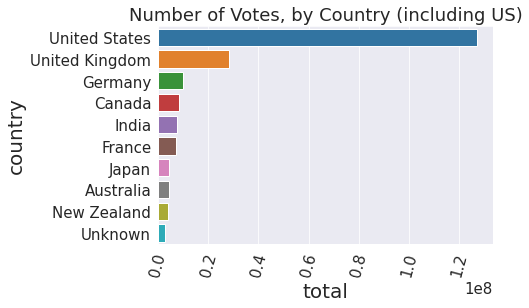

In [ ]:
#matplotlib.rcParams['font.size'] = 100

plt.figure(figsize=(6,4))
plt.xticks(rotation=75)
plt.title('Number of Votes, by Country (including US)')
plt.xlabel('Votes', fontsize=20)
plt.ylabel('Country', fontsize=20)
sns.barplot(x=full_votes_df.total.head(10), y=full_votes_df.country.head(10));

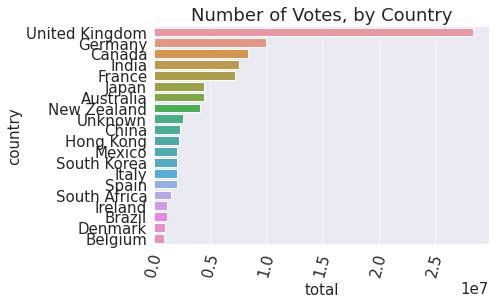

In [ ]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=75)
plt.title('Number of Votes, by Country')
sns.barplot(x=full_votes_df.total.iloc[1:21], y=full_votes_df.country.iloc[1:21]);

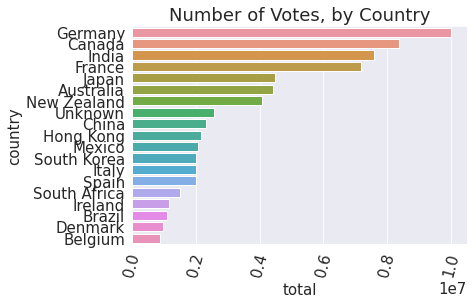

In [ ]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=75)
plt.title('Number of Votes, by Country')
sns.barplot(x=full_votes_df.total.iloc[2:21], y=full_votes_df.country.iloc[2:21]);

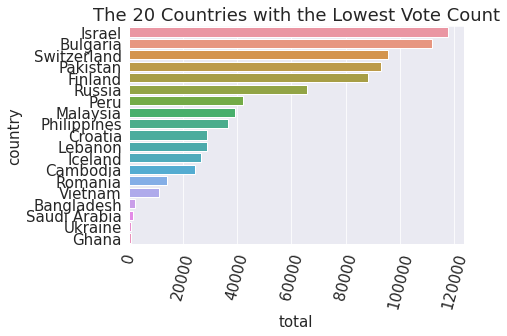

In [ ]:
plt.figure(figsize=(6, 4))
plt.xticks(rotation=75)
plt.title('The 20 Countries with the Lowest Vote Count')
sns.barplot(x=full_votes_df.total.iloc[-20:-1], y=full_votes_df.country.iloc[-20:-1]);

### Let's see where the ratings are clustered by plotting value density.

#### All Ratings for United States, United Kingdom and India

In [ ]:
sns.kdeplot(final_df[(final_df.country == 'United States') |
                     (final_df.country == 'United Kingdom') |
                     (final_df.country == 'India')].averageRating,
            hue=final_df[(final_df.country == 'United States') |
                                   (final_df.country == 'United Kingdom') |
                                   (final_df.country == 'India')].country);

### Let's create a dataframe containing some countries we are interested in, not including 'United States' or other major outliers which can make the graph difficult to read.

In [ ]:
country_density_list = ['Germany', 'Canada', 'France', 'Japan',
                        'Australia', 'New Zealand', 'China']

country_density_df = pd.DataFrame()

for country in country_density_list:
    country_density_df = pd.concat([country_density_df, final_df[final_df.country == country]])

## We can draw a custom graph on the fly using this MultiSelect Widget.  Choose as many countries as you like!

SelectMultiple(description='Countries', options=('Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium',…

Button(description='Click Me!', style=ButtonStyle())

Output()

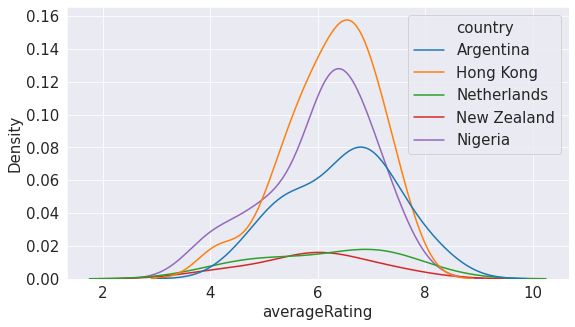

In [16]:
from IPython.display import display

countries = widgets.SelectMultiple(
  options=list(final_df.country[final_df.country_count == 1].sort_values().unique()),
  value=[],
  #rows=10,
  description='Countries',
  disabled=False
  )

bttn = widgets.Button(
  description='Click me',
  disabled=False,
  button_style='', # 'success', 'info', 'warning', 'danger' or ''
  tooltip='Click me',
  icon='check'
  )

display(countries)

button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
  country_density_df = pd.DataFrame()
  for country in countries.value:
    country_density_df = pd.concat([country_density_df, final_df[final_df.country == country]])
  with output:
    sns.kdeplot(country_density_df.averageRating, hue=country_density_df.country);

button.on_click(on_button_clicked)

### These are the ten most commonly used words throughout all of the descriptions, many of them unsurprising.

In [ ]:
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False).head(1000), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

top_words.head(10)

### The pie chart below displays the frequency of all words across all descriptions.  It gets far too illegible; let's break it down further, because...

In [ ]:
matplotlib.rcParams['font.size'] = 15
plt.figure(figsize=(16, 8))
plt.pie(top_words.frq, labels=top_words.word, autopct='%1.1f%%', startangle=180);

### ...the top ten words alone make up over 35% of the word usage; of that 35%, the word 'a' makes up over a fifth.

In [ ]:
top_words.percentage.head(10).sum()

In [ ]:
plt.figure(figsize=(16, 8))
plt.fontsize=15
plt.pie(top_words.frq.head(10), labels=top_words.word.head(10), autopct='%1.1f%%', startangle=180);

### Word frequency for US in descending order.

In [ ]:
netflix_us_df = netflix_df[netflix_df.country == 'United States']

desc_list2 = []
for desc in netflix_us_df.description:
    desc = desc.lower()
    desc_list2.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list2 = []
for desc in desc_list2:
    for word in desc:
        desc_word_list2.append(word.strip())
        
desc_word_pd2 = pd.DataFrame(desc_word_list2, columns=['word'])
        
desc_words_df2 = pd.DataFrame(desc_word_list2, columns=['word'])
desc_words_grp2 = pd.DataFrame(desc_words_df2.groupby('word')['word'].count())
desc_words_grp2 = desc_words_grp2.rename(columns={'word':'frq'})

top_words_us = pd.DataFrame(desc_words_grp2.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_us = top_words_us.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_us['percentage'] = top_words_us.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_us['country'] = 'United States'

top_words_us

### Word frequency for India, in descending order.

In [ ]:
netflix_india_df = netflix_df[netflix_df.country == 'India']

desc_list3 = []
for desc in netflix_india_df.description:
    desc = desc.lower()
    desc_list3.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list3 = []
for desc in desc_list3:
    for word in desc:
        desc_word_list3.append(word.strip())
        
desc_word_pd3 = pd.DataFrame(desc_word_list3, columns=['word'])
        
desc_words_df3 = pd.DataFrame(desc_word_list3, columns=['word'])
desc_words_grp3 = pd.DataFrame(desc_words_df3.groupby('word')['word'].count())
desc_words_grp3 = desc_words_grp3.rename(columns={'word':'frq'})

top_words_india = pd.DataFrame(desc_words_grp3.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_india = top_words_india.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_india['percentage'] = top_words_india.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_india['country'] = 'India'

top_words_india

### Word frequency for UK, in descending order.

In [ ]:
netflix_uk_df = netflix_df[netflix_df.country == 'United Kingdom']

desc_list4 = []
for desc in netflix_uk_df.description:
    desc = desc.lower()
    desc_list4.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list4 = []
for desc in desc_list4:
    for word in desc:
        desc_word_list4.append(word.strip())
        
desc_word_pd4 = pd.DataFrame(desc_word_list4, columns=['word'])
        
desc_words_df4 = pd.DataFrame(desc_word_list4, columns=['word'])
desc_words_grp4 = pd.DataFrame(desc_words_df4.groupby('word')['word'].count())
desc_words_grp4 = desc_words_grp4.rename(columns={'word':'frq'})

top_words_uk = pd.DataFrame(desc_words_grp4.frq.sort_values(ascending=False).head(1000), columns=['frq'])
top_words_uk = top_words_uk.reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words_uk['percentage'] = top_words_uk.frq.map(lambda x: (x / top_words_us.frq.sum()) * 100)
top_words_uk['country'] = 'United Kingdom'

top_words_uk

### The top five words for all the countries are identical, except for their position on the list.

In [ ]:
#movies_added = no_2001[no_2001.type == 'Movie'].groupby('year_added')['title'].count()
#movies_added

#tv_added = no_2001[no_2001.type == 'TV Show'].groupby('year_added')['title'].count()
#tv_added

#no_2001 = final_df[final_df.year_added != 2001]
#years = sorted(no_2001.year_added.unique())
#tv = tv_added.to_list()
#movies = movies_added.to_list()
#print(years, tv, movies)

In [ ]:
#plt.plot(years, tv, 'b-x', linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy');
#plt.plot(years, movies, 'r--o', linewidth=4, markersize=12);
#plt.title('Movies and TV Shows added to Netflix By Year')
#plt.legend(['Movies', 'TV Shows'])
#plt.xlabel('Year'); plt.ylabel('Titles Added');

### Now let's look at some of the least common words.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(64, 32))
matplotlib.rcParams['font.size'] = 50
axes[0].pie(top_words_us.frq.tail(20), labels=top_words_us.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[0].set_title('United States')
axes[1].pie(top_words_india.frq.tail(20), labels=top_words_india.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[1].set_title('India')
axes[2].pie(top_words_uk.frq.tail(20), labels=top_words_uk.word.tail(20), autopct='%1.1f%%', startangle=180);
axes[2].set_title('United Kingdom')

plt.tight_layout(pad=2);

### The above pie charts show the 20 least common descriptive words for US, India and UK.

### Below is a scatterplot of 'averageRating' VS 'numVotes'.

In [ ]:
matplotlib.rcParams['font.size'] = 10
plt.figure(figsize=(16,8))
sns.scatterplot(final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).averageRating, final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).numVotes, hue=final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).country.tolist());

In [ ]:
matplotlib.rcParams['font.size'] = 10
plt.figure(figsize=(16,8))
sns.scatterplot(final_df[(final_df.averageRating >= 5) & ((final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India'))].sort_values('averageRating', ascending=False).averageRating, final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).numVotes, hue=final_df[(final_df.country == 'United States') |
                         (final_df.country == 'United Kingdom') |
                         (final_df.country == 'India')].sort_values('averageRating', ascending=False).country.tolist());

## Asking and Answering Questions

### Explore differences between, as well as similarities among, content available in different countries

### Question 1: What are the least common words used in description?

In [ ]:
desc_list = []
for desc in netflix_df.description:
    desc = desc.lower()
    desc_list.append(desc.replace('_', ' ').replace(', ', ' ').replace('.', ' ').replace('-', ' ').split())
    
desc_word_list = []
for desc in desc_list:
    for word in desc:
        desc_word_list.append(word.strip())
        
desc_word_pd = pd.DataFrame(desc_word_list, columns=['word'])
        
desc_words_df = pd.DataFrame(desc_word_list, columns=['word'])
desc_words_grp = pd.DataFrame(desc_words_df.groupby('word')['word'].count())
desc_words_grp = desc_words_grp.rename(columns={'word':'frq'})

top_words = pd.DataFrame(desc_words_grp.frq.sort_values(ascending=False).head(1000), columns=['frq']).reset_index() # reset_index() allows us to create a new index beginning from 0 and, ultimately, more easily drop unneccessary columns

top_words['percentage'] = top_words.frq.map(lambda x: (x / top_words.frq.sum()) * 100)

In [ ]:
uc_words = top_words[top_words.frq <= 50].sample(100).tail(10)[['word', 'frq', 'percentage']].reset_index().drop('index', axis=1)
uc_words.sort_values('frq', ascending=False)

### Here we have a list of 10 of the LEAST commonly used words, generated by taking the tail of a random sample of 100 of the words whose frequency is 75 or less.

### Question 2: Which country consistently gives the highest ratings?

In [ ]:
us_ratings = final_df[final_df.country == 'United States'].averageRating
uk_ratings = final_df[final_df.country == 'United Kingdom'].averageRating
india_ratings = final_df[final_df.country == 'India'].averageRating

In [ ]:
plt.hist([us_ratings, uk_ratings, india_ratings], 
         stacked=True);
plt.legend(['United States', 'United Kingdom', 'India']);

### Question 3: Because India consistently gives the highest ratings to its available content, which type of content is preferred in India: Movie or TV Show?

In [ ]:
india_rating_tv = final_df[(final_df.country == 'India')].groupby('type')['averageRating'].mean()
india_rating_movie = final_df[(final_df.country == 'India') & (final_df.type == 'Movie')]['averageRating'].mean()

plt.hist([india_rating_tv, india_rating_movie]);

plt.legend(['Movie', 'TV Show']);

### It appears that India, as a country, prefers the TV Shows on Netflix over the Movies.

### Question 4: Does Netflix availability follow the Pareto Distribution?

### For the Pareto Distribution to hold for overall access to content by country, the top 20% of the countries in the list of content amount should account for 80% of the overall usage.  Let's see if this is the case.

In [ ]:
matplotlib.rcParams['font.size'] = 15

xplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = final_df.groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)
plt.xticks(rotation=75)
plt.plot(xplt, yplt)

### This graph closely mirrors a Pareto Distribution.

## Inferences and Conclusion

### There are obviously many interrelations between the data in this set, however, it appears that a prime takeaway is that TV Shows are valued more than movies in today's world;  in addition, it appears that India is a fast growing market which uses the rating system more favorably than some other, Western countries.

## References and Future Work

* https://www.kaggle.com/shivamb/netflix-shows
* https://datasets.imdbws.com/

* There should be more care taken when comparing titles by country.  There are a number of titles which are available in multiple countries and these combinations are counted as their own 'country'.

In [ ]:
!pip install jovian --upgrade -q
import jovian

In [ ]:
jovian.commit(project_name="Netflix-Data-Analysis", files=['netflix_df.csv'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
